# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before. But how do you get your own data into PyTorch?

One of the ways to do so is via custom datasets.

## Domain libraries

Depending on what you're working on (vision, text, audio, recommendation) you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Import necesseary libraries and set up device-agnostic code

In [1]:
import torch
import torch.nn

print(torch.__version__)

# Make device agnostic code
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

2.7.0
Using mps device


## 1. Get the data

Our dataset is a subset of the Food101 dataset. Food101 starts with 101 different classes of food and 1000 images per class. Our dataset starts with 3 classes of food and only 10% of the images.

Why do this?

When starting our ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it....
if image_path.is_dir():
    print(f"{image_path} directory7 already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory7 already exists... skipping download


/Users/mhehl/Documents/PyTorch - Course/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Becoming one with the data (data preparation and data exploration)

In [3]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's Pillow
5. We'll then show the image and print metadata

In [5]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pich a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (tjhe image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
img

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Random image class: pizza
Random image height: 512
Random image width: 512


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

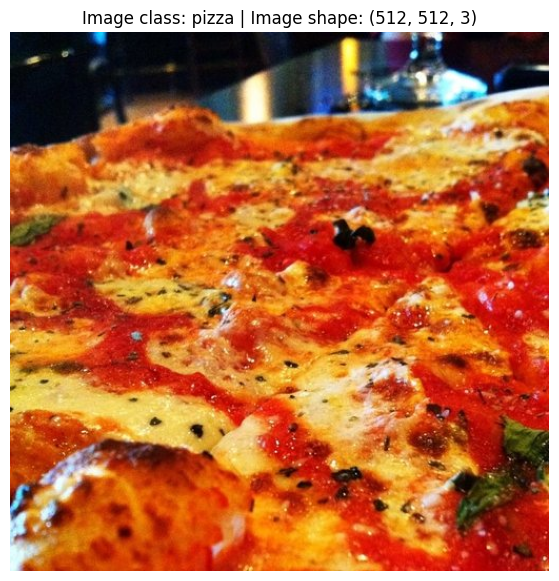

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch, we need to do the following:
1. Turn your target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently in a `torch.utils.data.DataLoader`


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model and perform data augmentation.

In [8]:
from torchvision import transforms

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image
    transforms.Resize(size=(64,64)),
    # Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [9]:
image_tensor = data_transform(img)
image_tensor.shape

torch.Size([3, 64, 64])

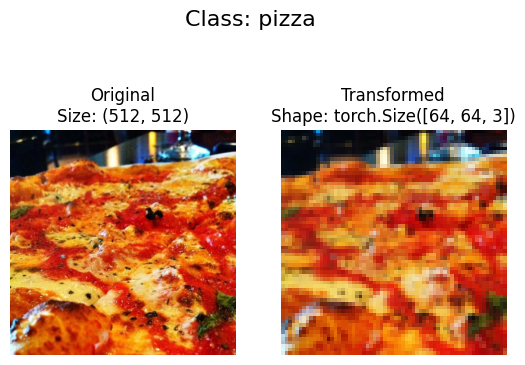

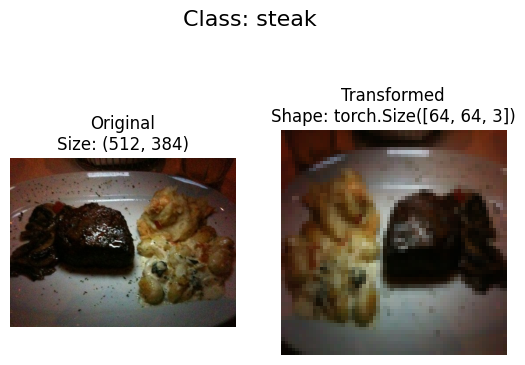

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Select random images from a path of images and loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)


            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform)


## 4. Option 1: Loading image data using Image Folder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [11]:
# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None)        # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get classnames 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [16]:
# Index on the train_data Dataset to get a sinfle image and a label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

In [17]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

### 4.1 Turn loaded images into a `DataLoader`
A `DataLoader` is going to help us turn our Dataset into iterables and we can customize the batch_size so our model can see `batch_size` images at a time.

In [18]:
# Turn train and test datasets into DataLoader's 
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x12727ebe0>,
 <torch.utils.data.dataloader.DataLoader at 0x12720e730>)

In [19]:
len(train_dataloader), len(test_dataloader)

(225, 75)

Same as the length of our dataset since we're using a batch_size equal to one.

In [20]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want ot be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Datasets


Pros: 
* Can create a `Dataset` our of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

In [21]:
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them.

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Find the class folder names in a target directory.
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")
    
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx


find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes 
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getiem()__` method to return a given sample when passed an index

In [24]:
# Write a custom dataset class
from torch.utils.data import Dataset
import pathlib

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initialize
    def __init__(self, target_directory: str, transform=None):
        super().__init__()
        # 3. Create class attributes
        self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory) 
    
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        return len(self.paths)
    
    # 6. Overwrite __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data and label (X,y)"""
        img = self.load_image(index=index)
        class_name = self.paths[index].parent.name      # expects path in format /data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [25]:
# Create a transform:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [26]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                      transform=test_transforms)

In [27]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1272bb6a0>,
 <__main__.ImageFolderCustom at 0x1272bb7f0>)

In [28]:
len(train_data), len(train_data_custom)

(225, 225)

In [29]:
len(test_data), len(test_data_custom)

(75, 75)

In [30]:
train_data_custom.classes, test_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [31]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [32]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib.plot
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [33]:
# 1. Create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n is to large
    if n > 10:
        n= 10
        display_shape=False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k =n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Make sure the dimension line up
        targ_imgage_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n, i+1)
        plt.imshow(targ_imgage_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_imgage_adjust.shape}"
            plt.title(title)
    

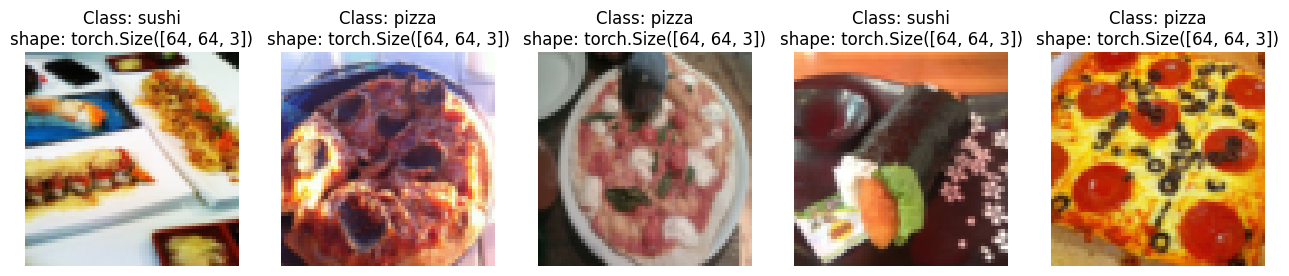

In [34]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

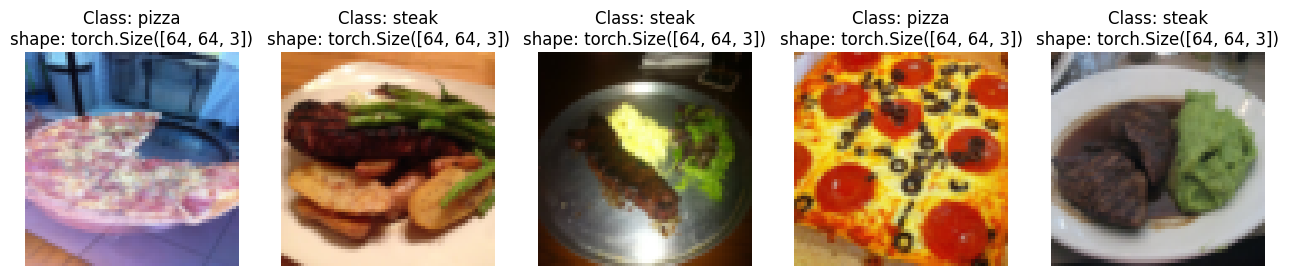

In [35]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custon loaded images into Dataloader

In [36]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_sampler=BATCH_SIZE)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x127633cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x127633eb0>)

In [37]:
# Get image and label from custom dataloader

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape

torch.Size([32, 3, 64, 64])

## 6. Data augmentation

Data augmentation is the process of artificially adding diversity to your training data. In the case of image data, this may mean applying various image transformations to the training images. This practice hopefully results in a model that is more generalizable to unseen data.

Let's take a look at one particular type of data aufmentation used to train PyTorch vision models to state of the art levels...

In [38]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

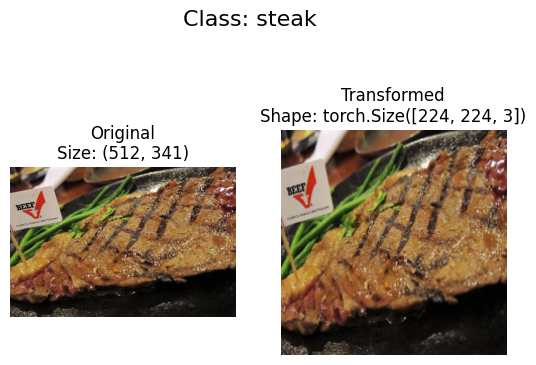

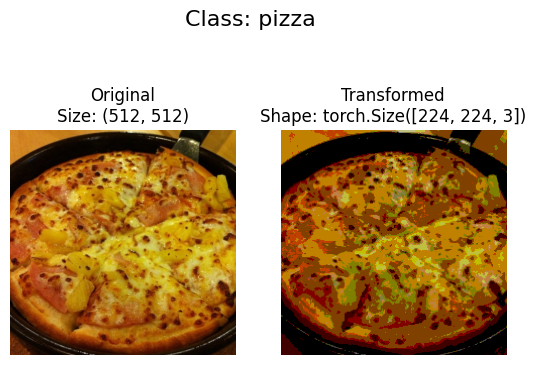

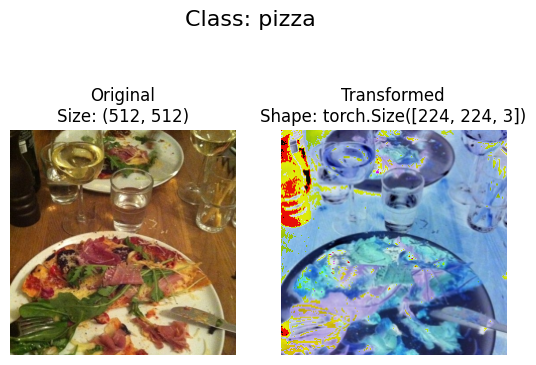

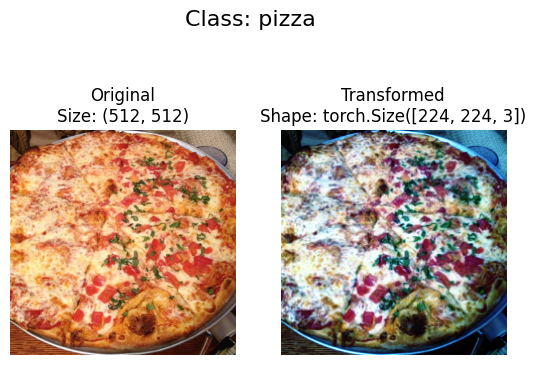

In [39]:
# Get image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random transformed images
plot_transformed_images(image_paths=image_path_list, 
                        transform=train_transform,
                        n=5,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [95]:
# create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [117]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32


train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     )

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    )

### 7.2 Create TinyVGG model class

In [72]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1690,
                      out_features=output_shape)
        )

    def forward(self, x):
        #x = self.conv_block_1(x)
        #print(x.shape)
        #x = self.conv_block_2(x)
        #print(x.shape)
        #x = self.classifier(x)
        #print(x.shape)
        #return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))       # benefits from operator fusion!!! -> avoids transportation between memory and compute  https://horace.io/brrr_intro.html

In [73]:
torch.manual_seed(42)
model0 = TinyVGG(input_shape=3, 
                 hidden_units=10,
                 output_shape=len(class_names)).to(device=device)

model0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image 

In [54]:
# Get image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [74]:
model0(image_batch.to(device))

tensor([[ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.2141e-02, -2.4331e-03,  9.7279e-03],
        [ 2.1635e-02, -4.3994e-03,  9.4989e-03],
        [ 2.2015e-02, -1.4427e-03,  7.8839e-03],
        [ 1.8531e-02, -9.9972e-05,  8.0369e-03],
        [ 1.9419e-02, -1.3767e-03,  1.1126e-02],
        [ 2.0323e-02, -1.7798e-03,  7.8779e-03],
        [ 1.9683e-02, -5.2765e-03,  9.3057e-03],
        [ 2.0531e-02, -3.9330e-03,  1.0121e-02],
        [ 2.2621e-02, -2.8323e-03,  1.1813e-02],
        [ 2.0226e-02,  4.4106e-04,  1.0933e-02],
        [ 2.0046e-02,  4.5708e-04,  1.0549e-02],
        [ 2.0669e-02,  2.8662e-03,  7.6834e-03],
        [ 2.1628e-02, -6.8455e-05,  9.2268e-03],
        [ 1.8115e-02, -1.2475e-04,  1.0741e-02],
        [ 1.9423e-02, -3.4742e-03,  1.1606e-02],
        [ 2.0772e-02,  1.3448e-03,  9.7040e-03],
        [ 2.0510e-02, -7.8605e-04,  8.4659e-03],
        [ 1.9368e-02, -7.8519e-04,  1.0480e-02],
        [ 2.3170e-02, -1.5725e-03,  8.5609e-03],
        [ 2.0672e-02

### 7.4 Using `torchinfo` to get information about our model

In [75]:
from torchinfo import summary

summary(model=model0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [76]:
# Create train_step()
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, device=device):

    # Put the model into train mode
    model.train()

    # setup train loss and train accurarcy
    train_loss, train_acc = 0,0

    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred_class)
    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc
 

In [ ]:
# Create test step

def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # turn on inference mode
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_lables = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_lables==y).sum().item() / len(test_pred_lables)
    # Adjust the metrics  to get average per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### 7.6 Creating a `train()` function

In [81]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + loss_fn +...

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer, 
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int= 5,
          device=device):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        # Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

        # Update our results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # 6. Return the filled results in the end
    return results

### 7.7 Train and evaluate our model

In [147]:
# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device=device)

# Set loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.01)

from timeit import default_timer as timer
start_time = timer()

# train model
model0_results = train(model=model0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

 10%|█         | 1/10 [00:00<00:03,  2.70it/s]

Epoch: 0 | Train loss: 1.1218 | Train acc: 0.41% | Test loss: 1.1596 | Test acc: 0.20%


 20%|██        | 2/10 [00:00<00:02,  2.78it/s]

Epoch: 1 | Train loss: 1.1501 | Train acc: 0.29% | Test loss: 1.1419 | Test acc: 0.20%


 30%|███       | 3/10 [00:01<00:02,  2.71it/s]

Epoch: 2 | Train loss: 1.1044 | Train acc: 0.29% | Test loss: 1.1028 | Test acc: 0.20%


 40%|████      | 4/10 [00:01<00:02,  2.77it/s]

Epoch: 3 | Train loss: 1.0982 | Train acc: 0.29% | Test loss: 1.1027 | Test acc: 0.26%


 50%|█████     | 5/10 [00:01<00:01,  2.79it/s]

Epoch: 4 | Train loss: 1.1014 | Train acc: 0.30% | Test loss: 1.1042 | Test acc: 0.26%


 60%|██████    | 6/10 [00:02<00:01,  2.79it/s]

Epoch: 5 | Train loss: 1.0937 | Train acc: 0.43% | Test loss: 1.1003 | Test acc: 0.26%


 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

Epoch: 6 | Train loss: 1.0916 | Train acc: 0.43% | Test loss: 1.1009 | Test acc: 0.26%


 80%|████████  | 8/10 [00:02<00:00,  2.80it/s]

Epoch: 7 | Train loss: 1.1032 | Train acc: 0.30% | Test loss: 1.1043 | Test acc: 0.26%


 90%|█████████ | 9/10 [00:03<00:00,  2.69it/s]

Epoch: 8 | Train loss: 1.1077 | Train acc: 0.30% | Test loss: 1.1011 | Test acc: 0.26%


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

Epoch: 9 | Train loss: 1.1048 | Train acc: 0.30% | Test loss: 1.1035 | Test acc: 0.26%
Total training time: 3.650 seconds


Very bad performance of our model!

### 7.8 Plot the loss curves of Model

A loss curve is a way of tracking your models progress over time.

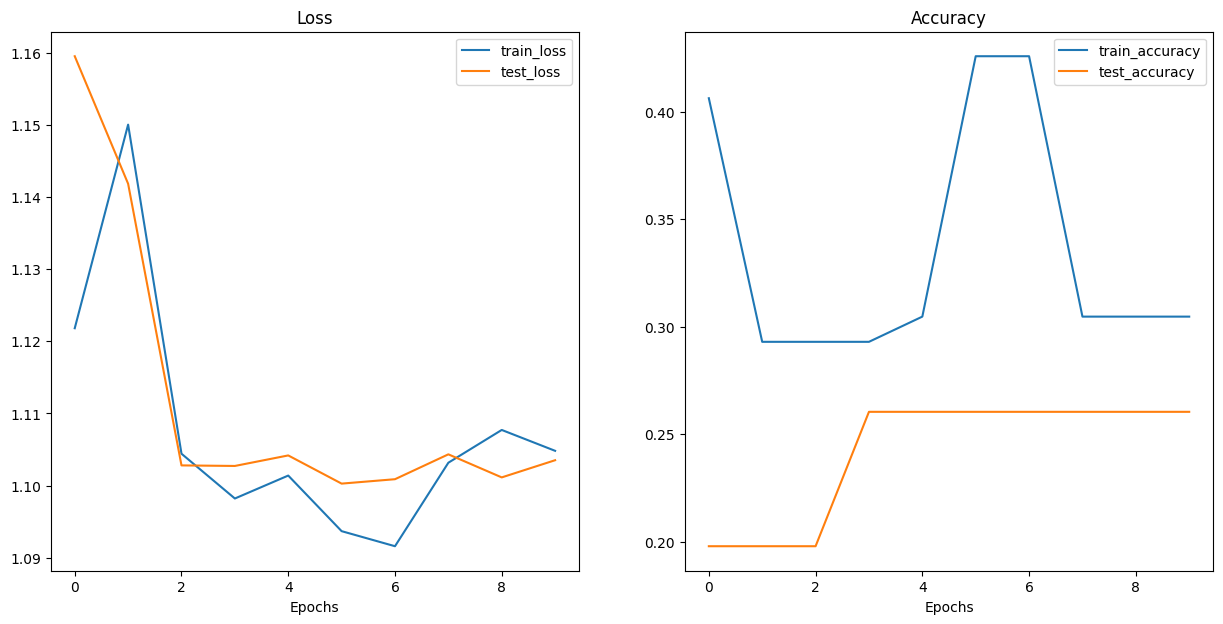

In [148]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of the results dictionary (training and test)"""
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the results dictionary (training and test)
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(acc))

    # Setup a plot
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(model0_results)

This does not look very good!

## 9. Model 1: TinyVGG with Data Augmentation

Now, let's ttry another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [138]:
# Create a training transfrom with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test datasets and dataloaders with data augmentation

In [140]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple) 

BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False)

### 9.3 Construct and train new model

This time we'll be using the same model architecture exceot this time we've augmented the training data

In [143]:
# Create model1 and send it to the target device
torch.manual_seed(42)
model1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)
model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders. Let's create a loss function and an optimizer and call upon our train() to train our model

In [153]:
# Set random seed
torch.manual_seed(42)

NUM_EPOCHS=10

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model1.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

model1_results = train(model=model1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Total training time for model: {end_time - start_time:.3f} seconds")

 10%|█         | 1/10 [00:00<00:03,  2.52it/s]

Epoch: 0 | Train loss: 1.0995 | Train acc: 0.29% | Test loss: 1.1605 | Test acc: 0.20%


 20%|██        | 2/10 [00:00<00:03,  2.63it/s]

Epoch: 1 | Train loss: 1.0930 | Train acc: 0.29% | Test loss: 1.1546 | Test acc: 0.26%


 30%|███       | 3/10 [00:01<00:02,  2.60it/s]

Epoch: 2 | Train loss: 1.1214 | Train acc: 0.30% | Test loss: 1.1515 | Test acc: 0.26%


 40%|████      | 4/10 [00:01<00:02,  2.59it/s]

Epoch: 3 | Train loss: 1.0883 | Train acc: 0.43% | Test loss: 1.1390 | Test acc: 0.26%


 50%|█████     | 5/10 [00:01<00:01,  2.57it/s]

Epoch: 4 | Train loss: 1.1143 | Train acc: 0.30% | Test loss: 1.1324 | Test acc: 0.26%


 60%|██████    | 6/10 [00:02<00:01,  2.57it/s]

Epoch: 5 | Train loss: 1.0882 | Train acc: 0.43% | Test loss: 1.1208 | Test acc: 0.26%


 70%|███████   | 7/10 [00:02<00:01,  2.62it/s]

Epoch: 6 | Train loss: 1.0857 | Train acc: 0.43% | Test loss: 1.1195 | Test acc: 0.26%


 80%|████████  | 8/10 [00:03<00:00,  2.63it/s]

Epoch: 7 | Train loss: 1.0846 | Train acc: 0.43% | Test loss: 1.1196 | Test acc: 0.26%


 90%|█████████ | 9/10 [00:03<00:00,  2.64it/s]

Epoch: 8 | Train loss: 1.1106 | Train acc: 0.30% | Test loss: 1.1223 | Test acc: 0.26%


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

Epoch: 9 | Train loss: 1.0842 | Train acc: 0.43% | Test loss: 1.1263 | Test acc: 0.26%
Total training time for model: 3.831 seconds


### 9.4 Plot the loss curves of the model

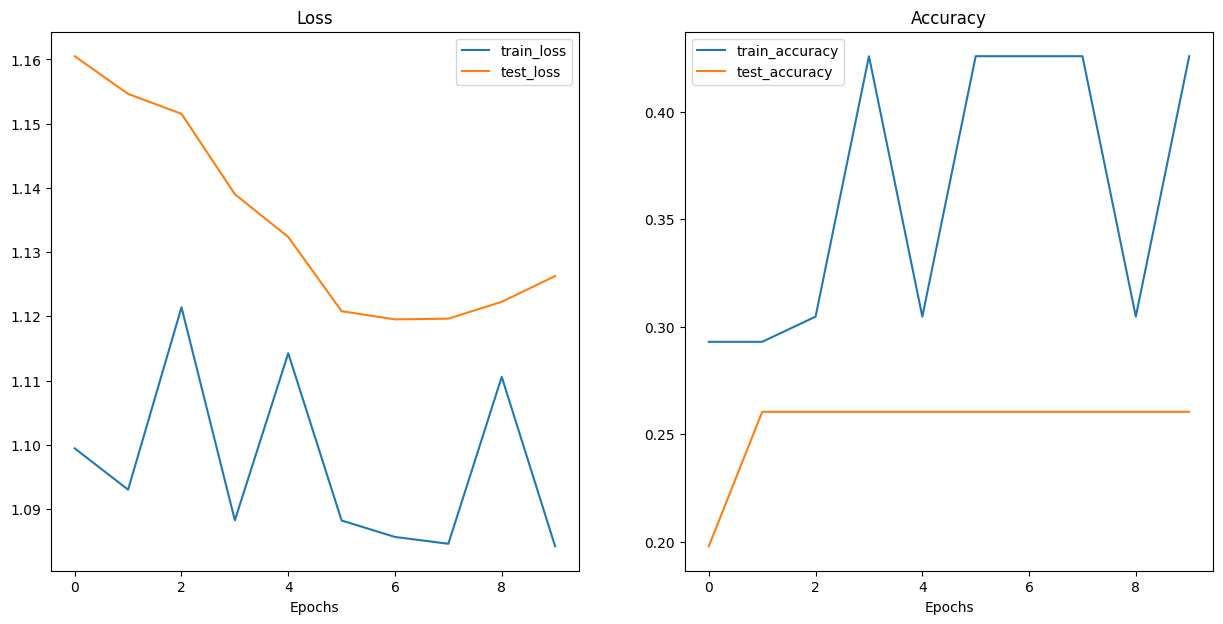

In [155]:
plot_loss_curves(model1_results)

It still doesn't look very good.

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other. There's a few different ways to do this:

1. Hard coding ()
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow

In [158]:
import pandas as pd

model0_df = pd.DataFrame(model0_results)
model1_df = pd.DataFrame(model1_results)
model0_df

train_loss  train_acc  test_loss  test_acc
0    1.121824   0.406250   1.159563  0.197917
1    1.150073   0.292969   1.141869  0.197917
2    1.104416   0.292969   1.102795  0.197917
3    1.098202   0.292969   1.102717  0.260417
4    1.101385   0.304688   1.104178  0.260417
5    1.093672   0.425781   1.100268  0.260417
6    1.091582   0.425781   1.100878  0.260417
7    1.103167   0.304688   1.104330  0.260417
8    1.107713   0.304688   1.101130  0.260417
9    1.104818   0.304688   1.103513  0.260417

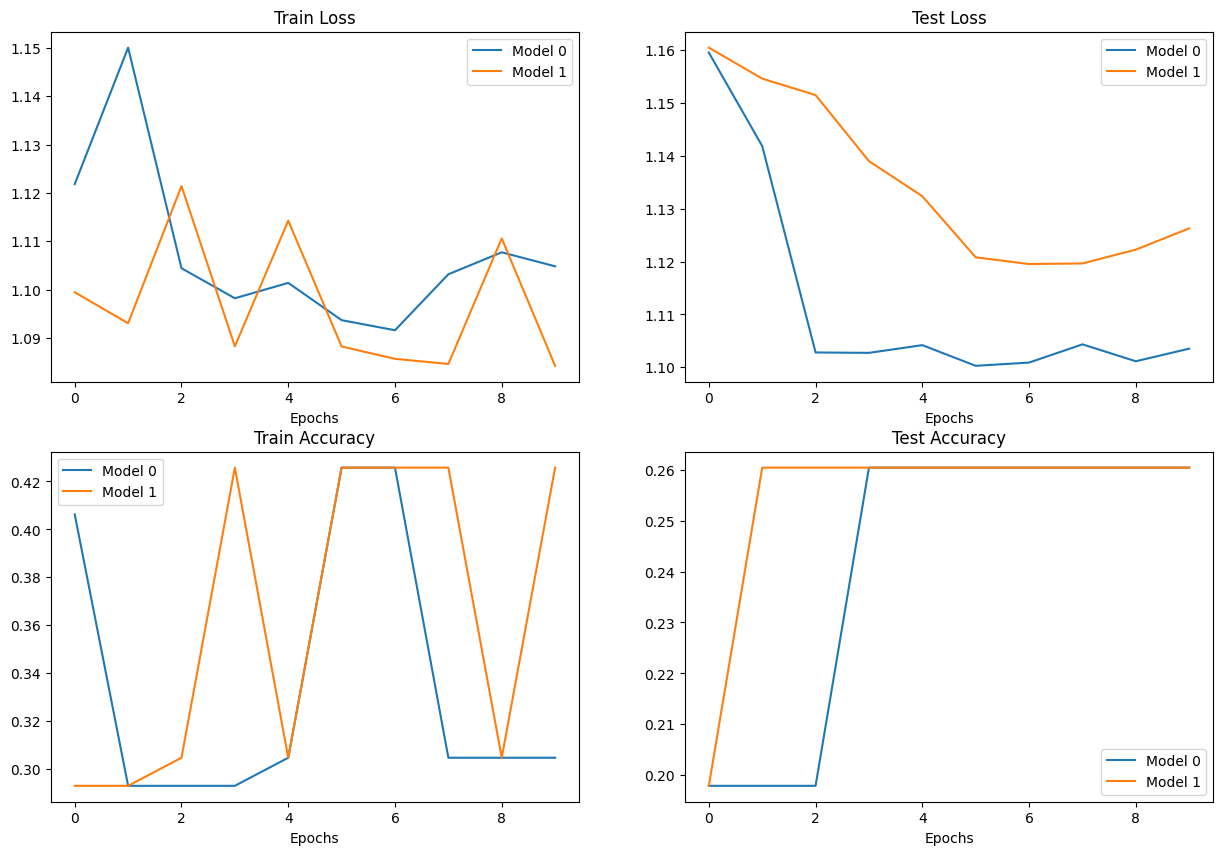

In [164]:
plt.figure(figsize=(15,10))

epochs = range(len(model1_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model0_df["train_loss"], label="Model 0")
plt.plot(epochs, model1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model0_df["test_loss"], label="Model 0")
plt.plot(epochs, model1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model0_df["train_acc"], label="Model 0")
plt.plot(epochs, model1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,4)
plt.plot(epochs, model0_df["test_acc"], label="Model 0")
plt.plot(epochs, model1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either the training and testing dataset.

In [165]:
# Download custom image
import requests
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # when downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)

else:
    print(f"{custom_image_path} already exists")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our sutom image is in the same format as the data our model was trained on.

* In tensor form with datatype `torch.float32`
* Of the shape 64x64x3
* On the right device

In [166]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(path=custom_image_path)
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

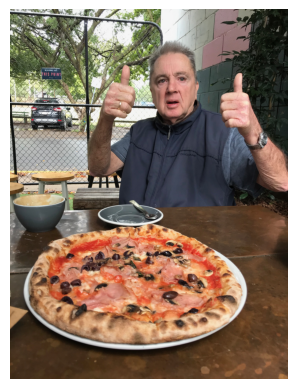

In [169]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)

In [171]:
custom_image_uint8.shape, custom_image_uint8.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

### 11.2 Making a prediction on a custom image with a trained PyTorch model

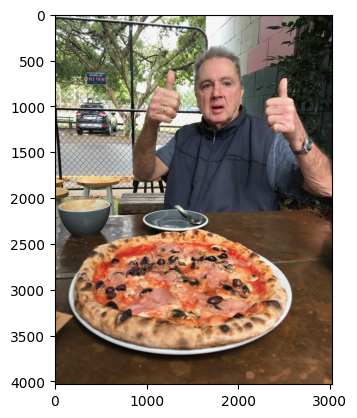

In [179]:
custom_image = custom_image_uint8.type(torch.float32) / 255

plt.imshow(custom_image.permute(1,2,0))

In [181]:
# Create transform pipeline to resize our image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [188]:
# Adding a batch size
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [187]:
# try to make a prediciton on an image in unit8 format
model1.eval()
with torch.inference_mode():
    y_logits = model1(custom_image_transformed.to(device).unsqueeze(dim=0))
y_logits

tensor([[-0.0043, -0.1967, -0.2369]], device='mps:0')

Note, to make a prediction on a custom iamge we had to:
* Load the image and turn it into a tensor
* Make sure the image has the same datatype as the model (torch.float32)
* Make sure the image has the same shape as the data the model was trained on (3,64,64) with a batch size... (1,3,64,64)
* Make sure the image is on the same device as our model

In [189]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [194]:
# Convert logits to prediction probabilities 
custom_image_pred_probs = torch.softmax(y_logits, dim=1)
print(custom_image_pred_probs)

# Convert prediction probabilities to prediction labels
custom_image_pred_label = custom_image_pred_probs.argmax(dim=1)
custom_image_pred_label

tensor([[0.3821, 0.3152, 0.3028]], device='mps:0')


tensor([0], device='mps:0')

In [193]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: Building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

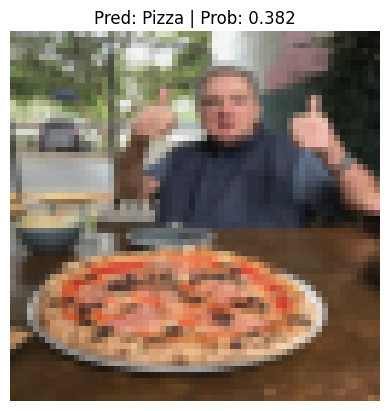

In [206]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names:List[str] = None,
                        transform=None,
                        device=device):
    """Makes a prediciton on an image with a trained model and plots the image and prediction"""

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) 

    # Divide the image pixel values by 255 to get them between [0,1]
    target_image = target_image/255
    if transform:
        target_image = transform(target_image)

    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        target_image_pred = model(target_image.to(device).unsqueeze(dim=0))

    # Convert logits to prediction probabilities 
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities to prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probabilities
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()].capitalize()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

pred_and_plot_image(model=model1, 
                    image_path=custom_image_path, 
                    class_names=class_names, 
                    transform=custom_image_transform, 
                    device=device)

## 12. Exercises


### 12.1 Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

* Train for longer, i.e., increase number of epochs
* Use larger models, e.g., increase number of hidden units or add more layers
* Change the learning rate
* Use less regularization

### 12.2 Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

### 12.3 Recreate model_0 we built in section 7.

In [200]:
model_exercise = TinyVGG(input_shape=3, hidden_units=10, output_shape=3).to(device)
model_exercise

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [201]:
random_img = torch.rand(size=(1,3,64,64))
model_exercise(random_img.to(device))

tensor([[-0.0114, -0.0513,  0.0155]], device='mps:0',
       grad_fn=<LinearBackward0>)

### 12.4 Create training and testing functions for model_0.

In [202]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

### 12.5 Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

In [203]:
torch.manual_seed(42)

model_exercise = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_exercise.parameters(),lr=0.001)

model_exercise_results = train(model_exercise, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=5)

 20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Epoch: 1 | train_loss: 1.1069 | train_acc: 0.3086 | test_loss: 1.0993 | test_acc: 0.2708


 40%|████      | 2/5 [00:00<00:01,  2.14it/s]

Epoch: 2 | train_loss: 1.0872 | train_acc: 0.4102 | test_loss: 1.0615 | test_acc: 0.5417


 60%|██████    | 3/5 [00:01<00:00,  2.17it/s]

Epoch: 3 | train_loss: 1.1271 | train_acc: 0.2812 | test_loss: 1.0455 | test_acc: 0.5417


 80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.0924 | test_acc: 0.1979


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

Epoch: 5 | train_loss: 1.1117 | train_acc: 0.3438 | test_loss: 1.0771 | test_acc: 0.5729


In [204]:
model_exercise_results = train(model_exercise, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=10)

 10%|█         | 1/10 [00:00<00:03,  2.31it/s]

Epoch: 1 | train_loss: 1.0999 | train_acc: 0.2812 | test_loss: 1.0895 | test_acc: 0.2604


 20%|██        | 2/10 [00:00<00:03,  2.46it/s]

Epoch: 2 | train_loss: 1.0801 | train_acc: 0.4805 | test_loss: 1.1024 | test_acc: 0.3229


 30%|███       | 3/10 [00:01<00:02,  2.52it/s]

Epoch: 3 | train_loss: 1.0693 | train_acc: 0.5352 | test_loss: 1.1203 | test_acc: 0.2812


 40%|████      | 4/10 [00:01<00:02,  2.55it/s]

Epoch: 4 | train_loss: 1.0947 | train_acc: 0.4102 | test_loss: 1.1190 | test_acc: 0.3125


 50%|█████     | 5/10 [00:01<00:01,  2.59it/s]

Epoch: 5 | train_loss: 1.0284 | train_acc: 0.5430 | test_loss: 1.0875 | test_acc: 0.3220


 60%|██████    | 6/10 [00:02<00:01,  2.58it/s]

Epoch: 6 | train_loss: 1.0960 | train_acc: 0.4258 | test_loss: 1.0685 | test_acc: 0.3210


 70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

Epoch: 7 | train_loss: 0.9795 | train_acc: 0.6094 | test_loss: 1.0903 | test_acc: 0.3324


 80%|████████  | 8/10 [00:03<00:00,  2.61it/s]

Epoch: 8 | train_loss: 1.0151 | train_acc: 0.4648 | test_loss: 1.1071 | test_acc: 0.3021


 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

Epoch: 9 | train_loss: 1.0389 | train_acc: 0.4336 | test_loss: 1.0795 | test_acc: 0.3428


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

Epoch: 10 | train_loss: 1.0182 | train_acc: 0.4609 | test_loss: 1.0533 | test_acc: 0.4924


In [205]:
model_exercise_results = train(model_exercise, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=20)

  5%|▌         | 1/20 [00:00<00:07,  2.50it/s]

Epoch: 1 | train_loss: 1.0568 | train_acc: 0.4023 | test_loss: 0.9649 | test_acc: 0.5862


 10%|█         | 2/20 [00:00<00:07,  2.53it/s]

Epoch: 2 | train_loss: 0.9426 | train_acc: 0.5273 | test_loss: 1.0499 | test_acc: 0.3636


 15%|█▌        | 3/20 [00:01<00:06,  2.55it/s]

Epoch: 3 | train_loss: 0.9290 | train_acc: 0.5391 | test_loss: 1.0743 | test_acc: 0.3324


 20%|██        | 4/20 [00:01<00:06,  2.57it/s]

Epoch: 4 | train_loss: 0.9828 | train_acc: 0.5742 | test_loss: 1.0728 | test_acc: 0.3116


 25%|██▌       | 5/20 [00:01<00:06,  2.50it/s]

Epoch: 5 | train_loss: 0.9996 | train_acc: 0.4531 | test_loss: 1.0397 | test_acc: 0.3229


 30%|███       | 6/20 [00:02<00:05,  2.53it/s]

Epoch: 6 | train_loss: 0.9764 | train_acc: 0.4688 | test_loss: 0.9593 | test_acc: 0.5729


 35%|███▌      | 7/20 [00:02<00:05,  2.55it/s]

Epoch: 7 | train_loss: 0.8701 | train_acc: 0.5547 | test_loss: 0.9774 | test_acc: 0.5634


 40%|████      | 8/20 [00:03<00:04,  2.57it/s]

Epoch: 8 | train_loss: 0.9549 | train_acc: 0.4844 | test_loss: 0.9663 | test_acc: 0.4328


 45%|████▌     | 9/20 [00:03<00:04,  2.58it/s]

Epoch: 9 | train_loss: 0.9752 | train_acc: 0.5078 | test_loss: 0.9534 | test_acc: 0.4725


 50%|█████     | 10/20 [00:03<00:03,  2.59it/s]

Epoch: 10 | train_loss: 1.0223 | train_acc: 0.6133 | test_loss: 1.0146 | test_acc: 0.4129


 55%|█████▌    | 11/20 [00:04<00:03,  2.59it/s]

Epoch: 11 | train_loss: 0.9727 | train_acc: 0.5078 | test_loss: 1.0641 | test_acc: 0.3220


 60%|██████    | 12/20 [00:04<00:03,  2.59it/s]

Epoch: 12 | train_loss: 0.9437 | train_acc: 0.4648 | test_loss: 1.1016 | test_acc: 0.2907


 65%|██████▌   | 13/20 [00:05<00:02,  2.61it/s]

Epoch: 13 | train_loss: 0.9808 | train_acc: 0.4570 | test_loss: 1.0433 | test_acc: 0.3627


 70%|███████   | 14/20 [00:05<00:02,  2.61it/s]

Epoch: 14 | train_loss: 0.8992 | train_acc: 0.5977 | test_loss: 0.9952 | test_acc: 0.4839


 75%|███████▌  | 15/20 [00:05<00:01,  2.60it/s]

Epoch: 15 | train_loss: 1.0764 | train_acc: 0.4648 | test_loss: 0.9415 | test_acc: 0.6051


 80%|████████  | 16/20 [00:06<00:01,  2.61it/s]

Epoch: 16 | train_loss: 0.9665 | train_acc: 0.4297 | test_loss: 0.9884 | test_acc: 0.4025


 85%|████████▌ | 17/20 [00:06<00:01,  2.61it/s]

Epoch: 17 | train_loss: 0.9830 | train_acc: 0.4688 | test_loss: 1.0601 | test_acc: 0.3324


 90%|█████████ | 18/20 [00:06<00:00,  2.59it/s]

Epoch: 18 | train_loss: 1.0388 | train_acc: 0.4805 | test_loss: 0.9969 | test_acc: 0.3845


 95%|█████████▌| 19/20 [00:07<00:00,  2.59it/s]

Epoch: 19 | train_loss: 0.9474 | train_acc: 0.4922 | test_loss: 0.9767 | test_acc: 0.3532


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

Epoch: 20 | train_loss: 0.9804 | train_acc: 0.4453 | test_loss: 0.9418 | test_acc: 0.5445


### 12.6 Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [214]:
class TinyVGG_wide(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3380,
                      out_features=output_shape)
        )

    def forward(self, x):
        #x = self.conv_block_1(x)
        #print(x.shape)
        #x = self.conv_block_2(x)
        #print(x.shape)
        #x = self.classifier(x)
        #print(x.shape)
        #return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) 
    
model_exercise2 = TinyVGG_wide(input_shape=3, hidden_units=20, output_shape=3).to(device=device)

In [215]:
model_exercise2_results = train(model=model_exercise2,
                                train_dataloader=train_dataloader_augmented,
                                test_dataloader=test_dataloader_augmented,
                                optimizer=optimizer,
                                epochs=20) 

  5%|▌         | 1/20 [00:01<00:35,  1.87s/it]

Epoch: 1 | train_loss: 1.0973 | train_acc: 0.4414 | test_loss: 1.0950 | test_acc: 0.5739


 10%|█         | 2/20 [00:02<00:19,  1.07s/it]

Epoch: 2 | train_loss: 1.0986 | train_acc: 0.3086 | test_loss: 1.0950 | test_acc: 0.5739


 15%|█▌        | 3/20 [00:02<00:13,  1.27it/s]

Epoch: 3 | train_loss: 1.0972 | train_acc: 0.4492 | test_loss: 1.0950 | test_acc: 0.5739


 20%|██        | 4/20 [00:03<00:10,  1.52it/s]

Epoch: 4 | train_loss: 1.0980 | train_acc: 0.3086 | test_loss: 1.0950 | test_acc: 0.5739


 25%|██▌       | 5/20 [00:03<00:08,  1.69it/s]

Epoch: 5 | train_loss: 1.0975 | train_acc: 0.4570 | test_loss: 1.0950 | test_acc: 0.5739


 30%|███       | 6/20 [00:04<00:07,  1.83it/s]

Epoch: 6 | train_loss: 1.0978 | train_acc: 0.3555 | test_loss: 1.0950 | test_acc: 0.5739


 35%|███▌      | 7/20 [00:04<00:06,  1.94it/s]

Epoch: 7 | train_loss: 1.0981 | train_acc: 0.3359 | test_loss: 1.0950 | test_acc: 0.5739


 40%|████      | 8/20 [00:05<00:05,  2.00it/s]

Epoch: 8 | train_loss: 1.0968 | train_acc: 0.4688 | test_loss: 1.0950 | test_acc: 0.5739


 45%|████▌     | 9/20 [00:05<00:05,  2.06it/s]

Epoch: 9 | train_loss: 1.0971 | train_acc: 0.4570 | test_loss: 1.0950 | test_acc: 0.5739


 50%|█████     | 10/20 [00:06<00:04,  2.10it/s]

Epoch: 10 | train_loss: 1.1011 | train_acc: 0.3516 | test_loss: 1.0950 | test_acc: 0.5739


 55%|█████▌    | 11/20 [00:06<00:04,  2.15it/s]

Epoch: 11 | train_loss: 1.1007 | train_acc: 0.3398 | test_loss: 1.0950 | test_acc: 0.5739


 60%|██████    | 12/20 [00:06<00:03,  2.19it/s]

Epoch: 12 | train_loss: 1.0977 | train_acc: 0.4648 | test_loss: 1.0950 | test_acc: 0.5739


 65%|██████▌   | 13/20 [00:07<00:03,  2.19it/s]

Epoch: 13 | train_loss: 1.0972 | train_acc: 0.4219 | test_loss: 1.0950 | test_acc: 0.5739


 70%|███████   | 14/20 [00:07<00:02,  2.17it/s]

Epoch: 14 | train_loss: 1.1008 | train_acc: 0.3203 | test_loss: 1.0950 | test_acc: 0.5739


 75%|███████▌  | 15/20 [00:08<00:02,  2.22it/s]

Epoch: 15 | train_loss: 1.0984 | train_acc: 0.3125 | test_loss: 1.0950 | test_acc: 0.5739


 80%|████████  | 16/20 [00:08<00:01,  2.27it/s]

Epoch: 16 | train_loss: 1.0978 | train_acc: 0.3594 | test_loss: 1.0950 | test_acc: 0.5739


 85%|████████▌ | 17/20 [00:09<00:01,  2.21it/s]

Epoch: 17 | train_loss: 1.0975 | train_acc: 0.4492 | test_loss: 1.0950 | test_acc: 0.5739


 90%|█████████ | 18/20 [00:09<00:00,  2.26it/s]

Epoch: 18 | train_loss: 1.0982 | train_acc: 0.3555 | test_loss: 1.0950 | test_acc: 0.5739


 95%|█████████▌| 19/20 [00:09<00:00,  2.33it/s]

Epoch: 19 | train_loss: 1.0969 | train_acc: 0.4297 | test_loss: 1.0950 | test_acc: 0.5739


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

Epoch: 20 | train_loss: 1.1012 | train_acc: 0.3086 | test_loss: 1.0950 | test_acc: 0.5739
